In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt
import cv2
import utilitary as util

In [2]:
hf = h5py.File("../epfl4.h5", "r")

In [3]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)

#removes entries with 1 contour (impossible to rotate atm)
del use_key[184]
del use_key[459]

x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

In [4]:
#MIP the red channel
r_MIP = util.single_MIP(hf, list_keys[:50], axis = 2, channel=0)

#contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP,0.8,blur=5)

#pick some random img to preprocess
i=5
j=5
idx= np.random.randint(0,50,i*j)

#rotated image and rotated contour
bi_rot = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in idx
]

#contain the image cropped around the contour center of mass
plots = [
    util.crop_ctr_mass(
    bi_rot[i][0],
    bi_rot[i][1]
    ) for i in range(len(idx))
]

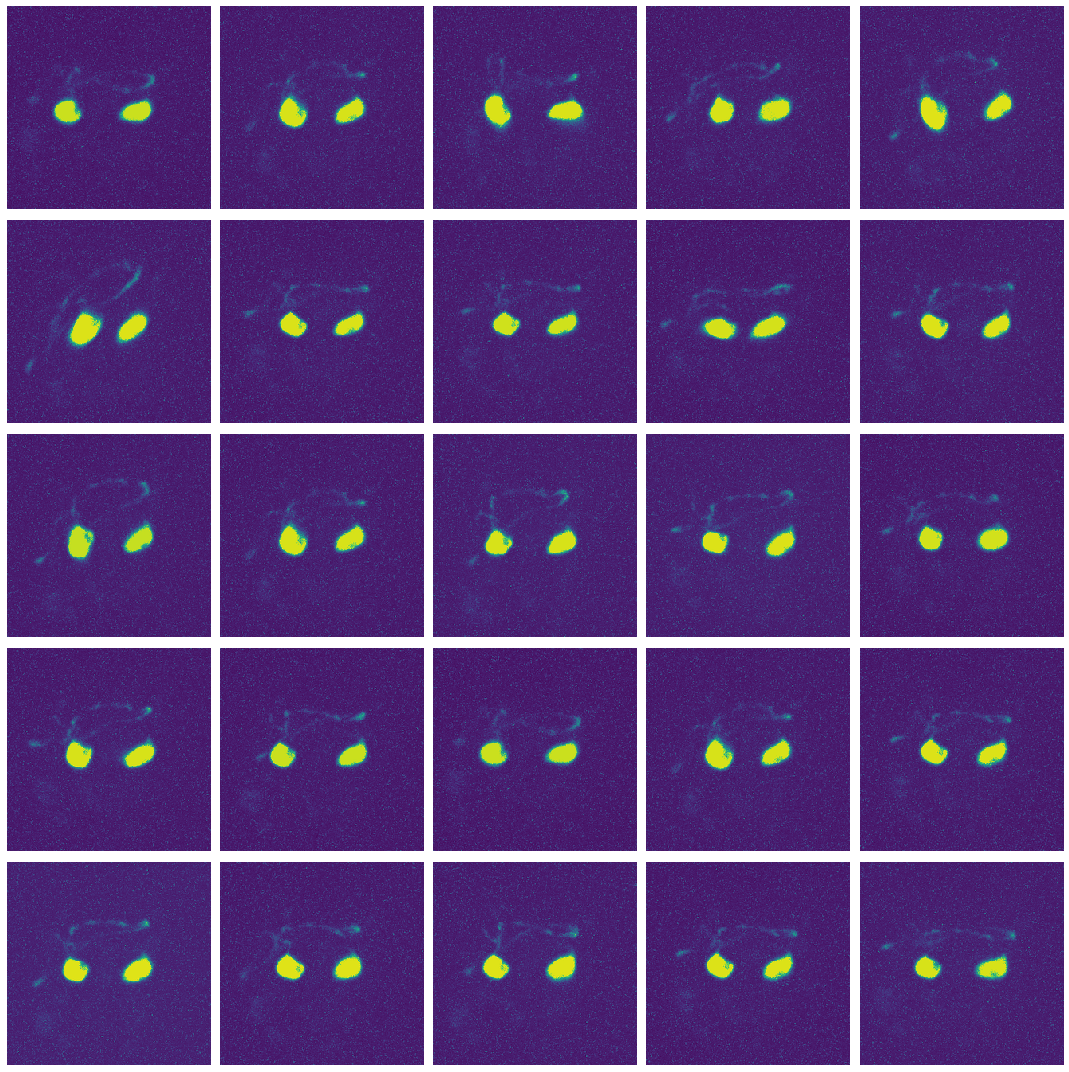

In [19]:
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [5]:
#MIP the red channel
r_MIP, g_MIP = util.MIP_GR(hf, list_keys, axis = 2)

#contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP,0.8,blur=5)

KeyboardInterrupt: 

In [4]:
# Find the mask of every frame of the red channel
masks_red = np.empty((len(use_key), x, y, z), dtype=np.int8)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][0]
    a = cv2.medianBlur(a, 5)
    masks_red[i] = np.where(a > 130, 1, 0)

In [ ]:
#np.save('mask.npy', masks_red)

In [5]:
#masks_red = np.empty((len(use_key), x, y, z), dtype=np.int8)
#masks_red = np.load('mask.npy')

In [5]:
# Apply the mask on the green channel
g_masked = np.empty((len(use_key), x, y, z), dtype=np.int16)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][1]
    a = cv2.medianBlur(a, 5)
    g_masked[i] = np.multiply(a, masks_red[i])

MemoryError: Unable to allocate 9.74 GiB for an array with shape (570, 512, 512, 35) and data type int16

In [ ]:
del masks_red

In [ ]:
#MIP the red channel
r_MIP, _ = util.MIP_GR(hf, list_keys, axis = 2)
g_MIP = util.np_MIP(g_masked, list_keys, axis=2)

#contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP,0.8,blur=5)

In [ ]:
del g_masked

In [ ]:
i = 5
j = 5
idx= np.random.randint(0,50,i*j)

In [ ]:
# Save the MIP to avoid loosing 2mn30 each time
#np.save('red.npy', r_MIP)
#np.save('green.npy', g_MIP)

In [ ]:
#r_MIP = np.empty((len(use_key), x, y, z), dtype=np.int8)
#r_MIP = np.load('red.npy')

In [ ]:
#g_MIP = np.empty((len(use_key), x, y, z), dtype=np.int8)
#g_MIP = np.load('mask.npy')

In [10]:
# indentify img with less than 2 contours
for k, l in enumerate(ctr_list):
    if len(l) < 2:
        print (k)

In [11]:
#rotated image and rotated contour
rotated_img = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

rotated_gr = [
    util.rot_img(g_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

#contain the image cropped around the contour center of mass
cropped_img = [
    util.crop_ctr_mass(
                        rotated_img[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

cropped_gre = [
    util.crop_ctr_mass(
                        rotated_gr[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

In [12]:
del rotated_img
del rotated_gr

In [13]:
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [14]:
# generate train and test set on cropped rotated img
slices_train_red = np.array([cropped_img[i] for i in keys_train])
slices_train_gr = np.array([cropped_gre[i] for i in keys_train])
slices_test_red  = np.array([cropped_img[i] for i in keys_test])
slices_test_gr  = np.array([cropped_gre[i] for i in keys_test])

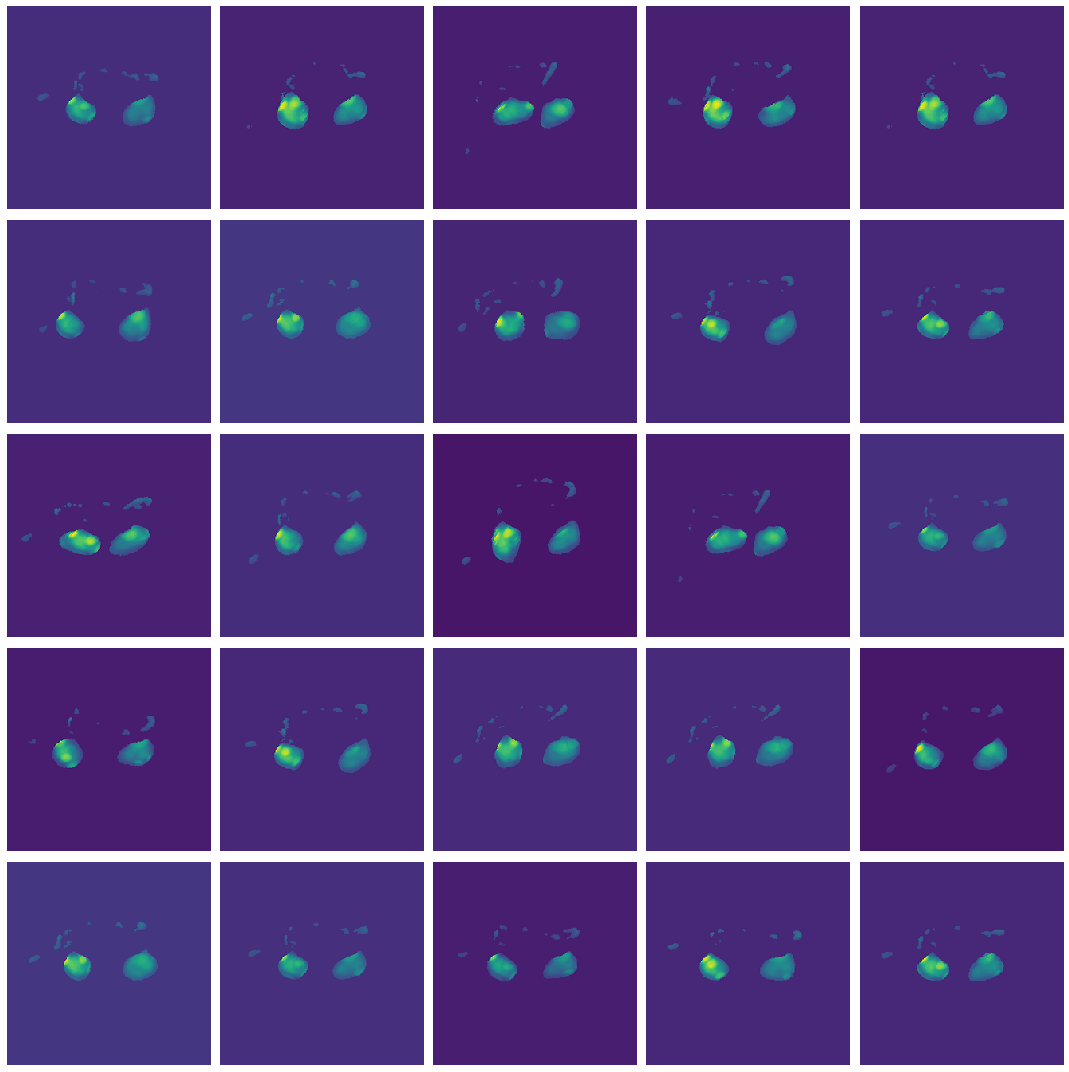

In [15]:
ne.plot.slices([cropped_gre[i] for i in idx], do_colorbars=True, grid = [i,j]);

In [ ]:
slices_train.shape

In [ ]:
#have a look at some random entries
j, i = 5, 5
idx= np.random.randint(0,50,i*j)
ne.plot.slices([slices_train[i] for i in idx], do_colorbars=True, grid = [i,j]);

In [16]:
# UNET architecture

vol_shape = slices_train_red[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

Instructions for updating:
Use fn_output_signature instead


In [17]:
del cropped_gre
del cropped_img

Epoch 1/10
100/100 [==============================] - 1029s 10s/step - loss: -42001.1172 - vxm_dense_transformer_loss: -42001.1211 - vxm_dense_flow_loss: 0.0924
Epoch 2/10
100/100 [==============================] - 1210s 12s/step - loss: -86042.5156 - vxm_dense_transformer_loss: -86042.5312 - vxm_dense_flow_loss: 0.1174
Epoch 3/10
100/100 [==============================] - 1318s 13s/step - loss: -97682.7656 - vxm_dense_transformer_loss: -97682.7969 - vxm_dense_flow_loss: 0.1458
Epoch 4/10
100/100 [==============================] - 1214s 12s/step - loss: -105821.3438 - vxm_dense_transformer_loss: -105821.3672 - vxm_dense_flow_loss: 0.1653
Epoch 5/10
100/100 [==============================] - 1019s 10s/step - loss: -98435.9453 - vxm_dense_transformer_loss: -98435.9688 - vxm_dense_flow_loss: 0.1673
Epoch 6/10
100/100 [==============================] - 937s 9s/step - loss: -104638.0234 - vxm_dense_transformer_loss: -104638.0469 - vxm_dense_flow_loss: 0.1752
Epoch 7/10
100/100 [============

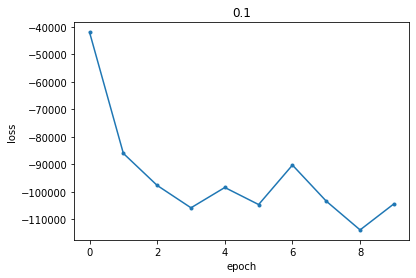

Epoch 1/10
100/100 [==============================] - 932s 9s/step - loss: -95639.1719 - vxm_dense_transformer_loss: -95639.3672 - vxm_dense_flow_loss: 0.1876
Epoch 2/10
100/100 [==============================] - 1080s 11s/step - loss: -91223.8906 - vxm_dense_transformer_loss: -91224.0781 - vxm_dense_flow_loss: 0.1709
Epoch 3/10
100/100 [==============================] - 1046s 10s/step - loss: -92835.2500 - vxm_dense_transformer_loss: -92835.4766 - vxm_dense_flow_loss: 0.1923
Epoch 4/10
100/100 [==============================] - 914s 9s/step - loss: -66795.4453 - vxm_dense_transformer_loss: -66795.6484 - vxm_dense_flow_loss: 0.2051
Epoch 5/10
100/100 [==============================] - 910s 9s/step - loss: -93932.3125 - vxm_dense_transformer_loss: -93932.5469 - vxm_dense_flow_loss: 0.1875
Epoch 6/10
100/100 [==============================] - 921s 9s/step - loss: -67345.6875 - vxm_dense_transformer_loss: -67345.9062 - vxm_dense_flow_loss: 0.1931
Epoch 7/10
100/100 [======================

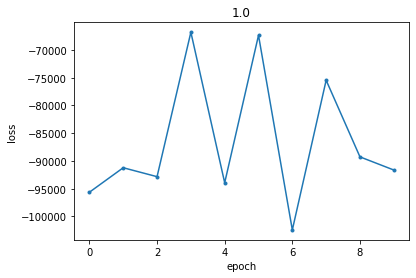

In [35]:
# Losses : MSE + smoothness (regularization) 
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-5,0,6)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 15)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "w_rotcrop" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [18]:
lambdas = np.logspace(-5,0,6)
# Load the best weights found
title = "w_rotcrop" + str(lambdas[-2]) + ".keras"
vxm_model.load_weights(title)

In [19]:
val_generator_red = util.vxm_data_generator(slices_test_red, 12, batch_size = 15)
val_input_red, _ = next(val_generator_red)
our_val_pred_red = vxm_model.predict(val_input_red);

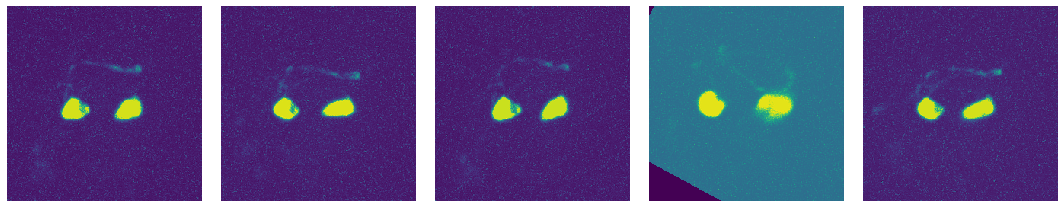

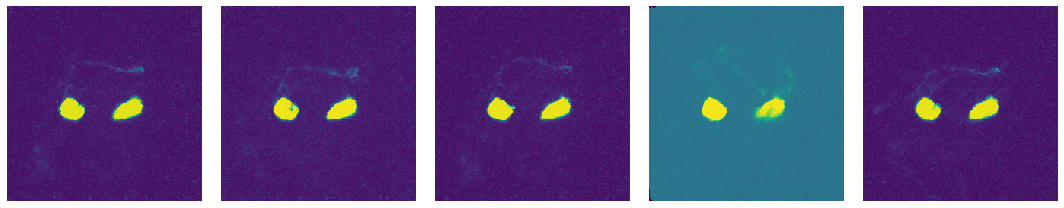

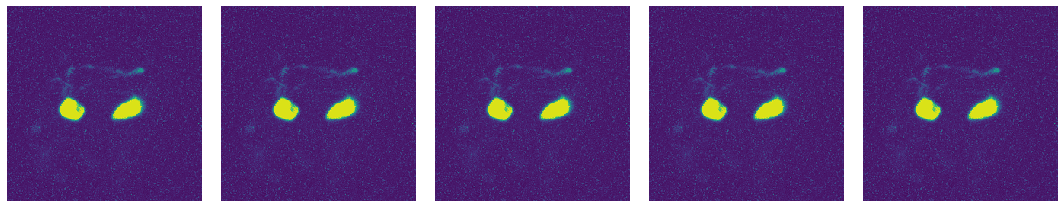

In [20]:
moving_r = np.squeeze(val_input_red[0])
fixed_r = np.squeeze(val_input_red[1])
moved_r = np.squeeze(our_val_pred_red[0])

a = [moved_r[i, ...] for i in range(5)]
b = [moving_r[i, ...] for i in range(5)]
c = [fixed_r[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

In [75]:
test = vxm_model.register(val_input[0],val_input[1])
first_vol = test[...,0]

In [ ]:
plt.imshow(first_vol[:,:,0])

In [ ]:
slices_train = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_train])
slices_test  = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_test])

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['CC', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,5)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
    # vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 20)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "weights_rchan" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [ ]:
# Load the best weights found
title = "weights_rchan" + str(lambdas[-1]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 52, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

In [23]:
###GREEN CANAL
#lambdas = np.logspace(-5,0,6)
# Load the best weights found
#title = "w_rotcrop" + str(lambdas[-2]) + ".keras"
#vxm_model.load_weights(title)

# Validation set generator
val_generator_gr = util.vxm_data_generator(slices_train_gr, 12, batch_size = 15)
val_input_gr, zero_phi = next(val_generator_gr)
our_val_pred_gr = vxm_model.predict([val_input_red[1],val_input_gr[0]]);

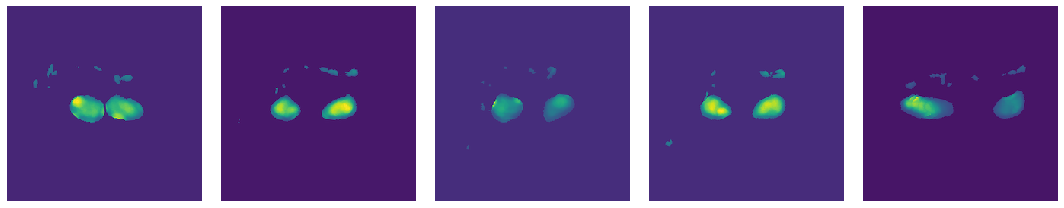

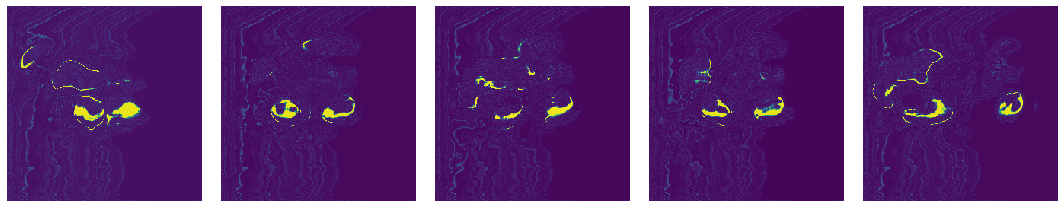

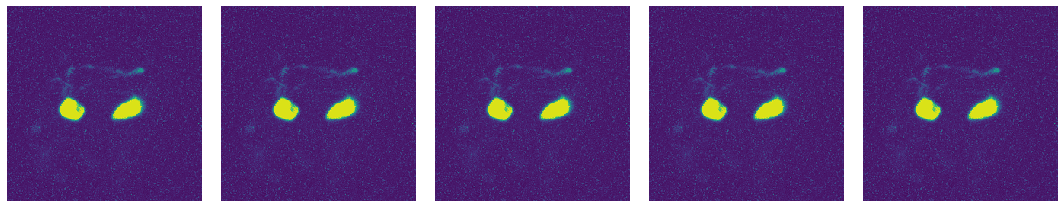

In [24]:
moving = np.squeeze(val_input_gr[0])
fixed = np.squeeze(val_input_red[1])
moved = np.squeeze(our_val_pred_gr[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

In [ ]:
overlap = vxm.py.utils.dice(our_val_pred, val_input, labels=lab['labels'])
means = []
means.append(np.mean(overlap))
print('scan %3d:   dice mean = %5.3f  std = %5.3f' % (i, np.mean(overlap), np.std(overlap)))

In [ ]:
class Dice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(y_pred.get_shape().as_list()) - 2
        vol_axes = list(range(1, ndims+1))

        top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
        bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

        div_no_nan = tf.math.divide_no_nan if hasattr(tf.math, 'divide_no_nan') else tf.div_no_nan
        dice = tf.reduce_mean(div_no_nan(top, bottom))
        return -dice